In [1]:
from ultralytics import YOLO
import os
from PIL import Image

import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [6]:
def get_most_recent_run(directory):
    # get train files
    files = [
        f for f in os.listdir(directory)
        if os.path.isdir(os.path.join(directory, f)) and f.startswith('train')
    ]
    if not files:
        print("No train files found in the directory.")
        return None

    # Find the most recent file by creation time
    most_recent_file = max(files, key=lambda f: os.path.getctime(os.path.join(directory, f)))

    return most_recent_file

In [7]:
path = '/blue/hulcr/eric.kuo/YOLOv10/runs/detect'
lastRun = get_most_recent_run(path)
weights = f'{path}/{lastRun}/weights/best.pt'
weights

'/blue/hulcr/eric.kuo/YOLOv10/runs/detect/train4/weights/best.pt'

In [4]:
model = YOLO(weights)

In [5]:
dataset_folder = '/blue/hulcr/eric.kuo/test_dataset/train'
images_folder = '/blue/hulcr/eric.kuo/test_dataset/train/images'
#dataset_folder = '/blue/hulcr/share/eric.kuo/Beetle_classifier/Data/00_Preprocessed_composite_images/train'
#images_folder = '/blue/hulcr/share/eric.kuo/Beetle_classifier/Data/00_Preprocessed_composite_images/train/images'

In [6]:
def create_predictions_folder(base_name, parent_directory):
    # Construct the initial folder path
    folder_path = os.path.join(parent_directory, base_name)
    count = 1

    # Increment folder name if it already exists
    while os.path.exists(folder_path):
        new_folder_path = os.path.join(parent_directory, f"{base_name}_{count}")
        if not os.path.exists(new_folder_path):
            os.rename(folder_path, new_folder_path)
            print(f"Renamed folder from {folder_path} to {new_folder_path}")
            return new_folder_path
        
        count += 1

    # Create the new folder
    os.makedirs(folder_path)
    print(f"Created folder: {folder_path}")

    return folder_path

In [7]:
previous_pred_folder = create_predictions_folder('labels', dataset_folder)

Renamed folder from /blue/hulcr/eric.kuo/test_dataset/train/labels to /blue/hulcr/eric.kuo/test_dataset/train/labels_2


In [8]:
output_folder = dataset_folder + '/labels'
os.makedirs(output_folder, exist_ok=True)

In [16]:
for root, dirs, files in os.walk(images_folder):
    for file in files:
        if file.endswith(('.png', '.jpg', '.jpeg', '.tiff', '.tif')):  # Add other image extensions if needed
            image_path = os.path.join(root, file)
            output_subfolder = os.path.join(output_folder, os.path.relpath(root, images_folder))
            os.makedirs(output_subfolder, exist_ok=True)
            
            predictions = model(image_path, device=0, verbose=False)
            
            output_txt_path = os.path.join(output_subfolder, os.path.splitext(file)[0] + ".txt")
            with open(output_txt_path, 'w') as f:
                for idx, prediction in enumerate(predictions[0].boxes.xywhn):
                    cls = int(predictions[0].boxes.cls[idx].item())
                    f.write(f"{cls} {prediction[0].item()} {prediction[1].item()} {prediction[2].item()} {prediction[3].item()}\n")
                    


Ultralytics YOLOv8.2.70 🚀 Python-3.11.9 torch-2.4.0 CUDA:0 (NVIDIA A100-SXM4-80GB, 81038MiB)
YOLOv10x summary (fused): 503 layers, 31,586,006 parameters, 0 gradients


### Check Annotations

In [2]:
def number_of_detections(annotations_folder):
    total_boxes = 0

    for root, dirs, files in os.walk(annotations_folder):
        for file in files:
            if file.endswith('.txt'):
                annotation_path = os.path.join(root, file)
                
                with open(annotation_path, 'r') as f:
                    # Count the number of lines in the annotation file
                    boxes_in_file = len(f.readlines())
                    total_boxes += boxes_in_file
    
    return total_boxes


annotations_folder = '/blue/hulcr/share/eric.kuo/Beetle_classifier/Data/00_Preprocessed_composite_images/train/labels'

total_detections = number_of_detections(annotations_folder)

print(f"Total number of bounding boxes: {total_detections}")

Total number of bounding boxes: 179701


In [3]:
def load_yolo_annotations(file_path):
    """Load YOLO format annotations from a text file."""
    annotations = []
    with open(file_path, 'r') as file:
        for line in file:
            class_id, x_center, y_center, width, height = map(float, line.strip().split())
            annotations.append((class_id, x_center, y_center, width, height))
    return annotations

In [4]:
def draw_bounding_boxes(image, annotations):
    """Draw bounding boxes on the image using the provided annotations."""
    fig, ax = plt.subplots(1)
    ax.imshow(image)

    image_width, image_height = image.size

    for annotation in annotations:
        class_id, x_center, y_center, width, height = annotation
        x_center *= image_width
        y_center *= image_height
        width *= image_width
        height *= image_height

        x_min = x_center - width / 2
        y_min = y_center - height / 2

        rect = patches.Rectangle((x_min, y_min), width, height, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        ax.text(x_min, y_min, f'Class {int(class_id)}', color='white', fontsize=12, bbox=dict(facecolor='red', alpha=0.5))

    plt.show()

In [5]:
def process_directory(image_folder, annotation_folder):
    """Process the directory and display images with bounding boxes."""
    for root, dirs, files in os.walk(image_folder):
        for file in files:
            if file.endswith(('.png', '.jpg', '.jpeg', '.tiff', '.tif')):
                image_path = os.path.join(root, file)
                annotation_path = os.path.join(annotation_folder, os.path.relpath(root, image_folder), os.path.splitext(file)[0] + ".txt")

                if os.path.exists(annotation_path):
                    image = Image.open(image_path)
                    annotations = load_yolo_annotations(annotation_path)
                    draw_bounding_boxes(image, annotations)

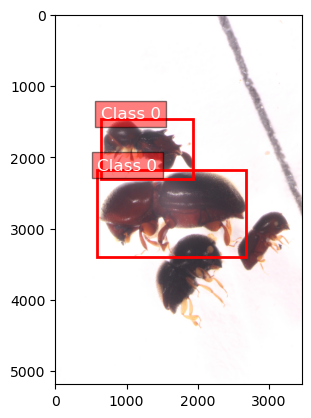

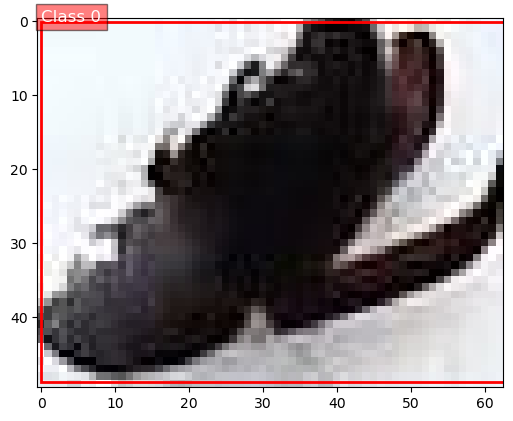

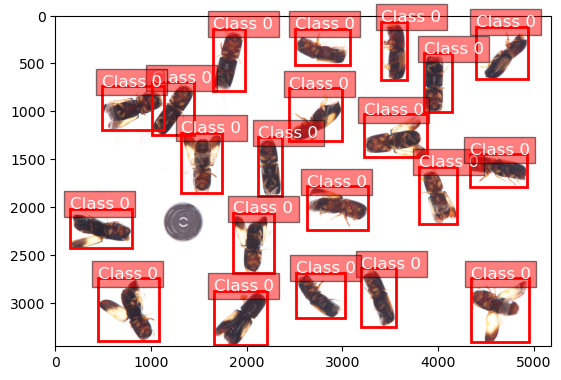

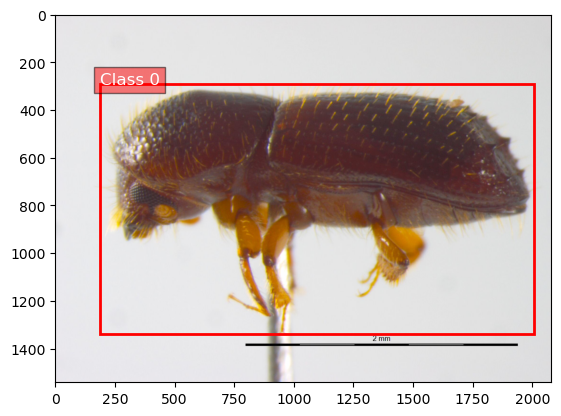

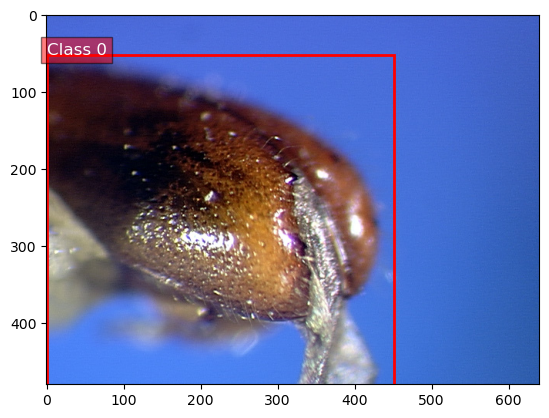

In [9]:
import random

annotations_folder = '/blue/hulcr/share/eric.kuo/Beetle_classifier/Data/00_Preprocessed_composite_images/train/labels'
images_folder = '/blue/hulcr/share/eric.kuo/Beetle_classifier/Data/00_Preprocessed_composite_images/train/images'
image_paths = []


for root, dirs, files in os.walk(images_folder):
        for file in files:
            if file.endswith(('.png', '.jpg', '.jpeg', '.tiff', '.tif')):
                image_path = os.path.join(root, file)
                image_paths.append(image_path)
                
for _ in range(5):
    random_image_path = random.choice(image_paths)
    relative_path = os.path.relpath(random_image_path, images_folder)
    annotation_path = os.path.join(annotations_folder, os.path.splitext(relative_path)[0] + ".txt")

    image = Image.open(random_image_path).convert("RGB")
    annotations = load_yolo_annotations(annotation_path)

    draw_bounding_boxes(image, annotations)